In [5]:
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2
import pandas
from scipy import ndimage
from PIL import Image 
import PIL 
from math import log10, sqrt
from sklearn.cluster import MiniBatchKMeans

In [6]:
Baboon = cv2.imread('Baboon.bmp', cv2.IMREAD_UNCHANGED)
Lena = cv2.imread('Lena.bmp', cv2.IMREAD_UNCHANGED)

#Utils

In [7]:
def imshow(*args, title=None, figsize=20, to_rgb=True, fontsize=12):
    if isinstance(figsize, int):
        figsize = (figsize, figsize)
    images = args[0] if type(args[0]) is list else list(args)
    if to_rgb:
        images = list(map(lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2RGB), images))
    if title is not None:
        assert len(title) == len(images), "Please provide a title for each image."
    plt.figure(figsize=figsize)
    for i in range(1, len(images)+1):
        plt.subplot(len(images), 1, i)
        if title is not None:
            plt.title(title[i-1], fontsize=fontsize)
        if images[i-1].ndim == 2:
            plt.imshow(images[i-1], cmap='gray')
        else:
            plt.imshow(images[i-1])
        plt.axis('off')

####RGB To HSI

In [4]:
#Calculate Intensity
def calc_intensity(red, blue, green):
    return np.divide(blue + green + red, 3)

In [5]:
#Calculate Saturation
def calc_saturation(red, blue, green):
    minimum = np.minimum(np.minimum(red, green), blue)
    saturation = 1 - (3 / (red + green + blue + 0.001) * minimum)

    return saturation

In [6]:
#Calculate Hue
def calc_hue(red, blue, green):
    hue = np.copy(red)

    for i in range(0, blue.shape[0]):
        for j in range(0, blue.shape[1]):
            hue[i][j] = 0.5 * ((red[i][j] - green[i][j]) + (red[i][j] - blue[i][j])) / \
                        math.sqrt((red[i][j] - green[i][j])**2 +
                                ((red[i][j] - blue[i][j]) * (green[i][j] - blue[i][j])))
            hue[i][j] = math.acos(hue[i][j])

            if blue[i][j] <= green[i][j]:
                hue[i][j] = hue[i][j]
            else:
                hue[i][j] = ((360 * math.pi) / 180.0) - hue[i][j]

    return hue

In [7]:
def RGB_TO_HSI(img):

    with np.errstate(divide='ignore', invalid='ignore'):

        #Load image with 32 bit floats as variable type
        bgr = np.float32(img)/255

        #Separate color channels
        blue = bgr[:,:,0]
        green = bgr[:,:,1]
        red = bgr[:,:,2]

        #Merge channels into picture and return image
        h = calc_hue(red, blue, green)
        s = calc_saturation(red, blue, green)
        i = calc_intensity(red, blue, green)
        hsi = cv2.merge((h, s, i))
        return hsi, h, s, i

####Quantize image

In [20]:
def quantize_global(x, k):
  k_means = MiniBatchKMeans(k, compute_labels=False)
  k_means.fit(x.reshape(-1, 1))
  labels = k_means.predict(x.reshape(-1, 1))
  q_x = k_means.cluster_centers_[labels]
  q_img = np.uint8(q_x.reshape(x.shape))
  return q_img

In [19]:
def quantize_channels(x, k):
  quantized_x = x.copy()
  for d in range(len(k)):
    channel = x[:, :, d].copy()
    k_means = MiniBatchKMeans(k[d], compute_labels=False)
    k_means.fit(channel.reshape(-1, 1))
    labels = k_means.predict(channel.reshape(-1, 1))
    quantized_x[:, :, d] = np.uint8(k_means.cluster_centers_[labels]).reshape(channel.shape)
  return quantized_x

In [9]:
def get_region_index(color_value):
    # colors divided into 8 regions for each color space
    eight_regions = [[0,31], [32,63], [64,95], [96,127], [128,159], [160,191], [192,223], [224,255]]
    for index, region_value in enumerate(eight_regions):
        if color_value >= region_value[0] and  color_value <= region_value[1]:
            return index

####MSE & PSNR

In [16]:
def mse(imageA, imageB):
	return np.square(imageA.astype('int16') - 
	                 imageB.astype('int16')).mean()

In [17]:
def PSNR(original, compressed):
  MSE = mse(original, compressed)
  if MSE == 0:
      # MSE is zero means no noise is present in the signal .Therefore PSNR have no importance.
      return 100
  max_pixel = 255.0
  psnr = 20 * log10(max_pixel / sqrt(MSE))
  return psnr

#6.1. Color space

##6.1.1

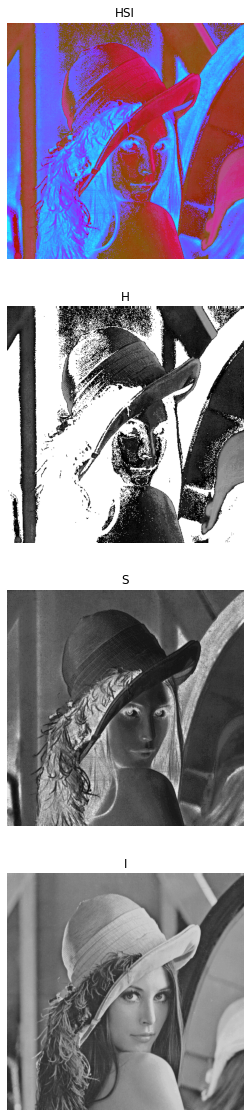

In [30]:
# Convert Lena to HSI format
lena_hsi, H, S, I = RGB_TO_HSI(Lena)
imshow(lena_hsi, H, S, I, title=['HSI','H','S','I'])

#6.2. Quantization

##6.2.1

In [26]:
Quan_64 = quantize_global(Lena, 64)
Quan_32 = quantize_global(Lena, 32)
Quan_16 = quantize_global(Lena, 16)
Quan_8 = quantize_global(Lena, 8)


imshow(Quan_64, title=['l = 64'], figsize = 10)
imshow(Quan_32, title=['l = 32'], figsize = 10)
imshow(Quan_16, title=['l = 16'], figsize = 10)
imshow(Quan_8, title=['l = 8'], figsize = 10)

pandas.DataFrame(columns=('K','MSE','PSNR'),
                 data=[('64', mse(Quan_64, Lena), PSNR(Quan_64, Lena)),
                       ('32', mse(Quan_32, Lena), PSNR(Quan_32, Lena)),
                       ('16', mse(Quan_16, Lena), PSNR(Quan_16, Lena)),
                       ('8', mse(Quan_8, Lena), PSNR(Quan_8, Lena))
                       ])

Output hidden; open in https://colab.research.google.com to view.

##6.2.2

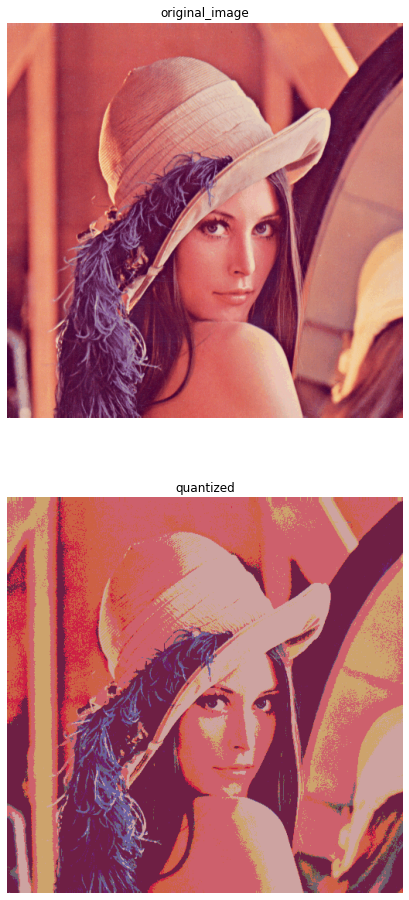

In [92]:
quantized_x = quantize_channels(Lena,[3,3,2])
imshow(Lena, quantized_x, title=['original_image','quantized'], figsize=16)

##6.2.3

,K,MSE
0,32,5.134082
1,16,18.714569
2,8,66.976254


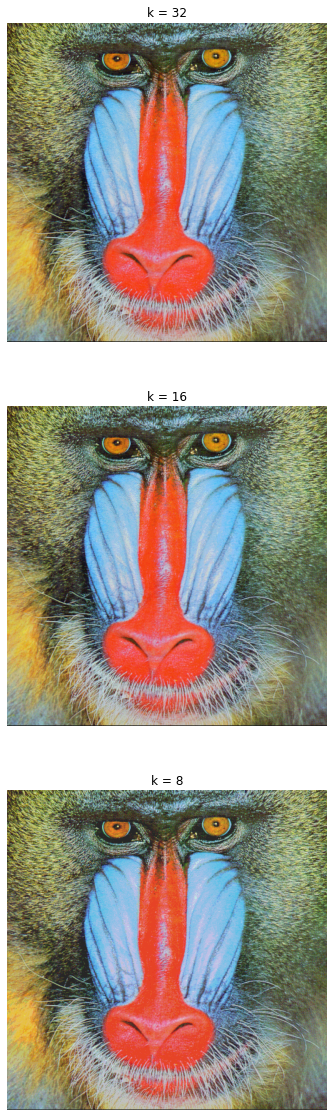

In [23]:
Quan_32 = quantize_global(Baboon, 32)
Quan_16 = quantize_global(Baboon, 16)
Quan_8 = quantize_global(Baboon, 8)

imshow(Quan_32, Quan_16, Quan_8, title=['k = 32', 'k = 16', 'k = 8'], figsize=20)

pandas.DataFrame(columns=('K','MSE'),
                 data=[('32', mse(Quan_32, Baboon)),
                       ('16', mse(Quan_16, Baboon)),
                       ('8', mse(Quan_8, Baboon))
                       ])